In [2]:
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import os
import lightgbm as lgb # ต้องติดตั้ง HomeBrew ก่อน
import cmake


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

'''
source pm2.5 = https://aqicn.org/city/bangkok/
Notebook: https://github.com/prasertcbs/scikitlearn_tutorial/blob/main/notebook/regressor_air_quality.ipynb
data source: https://aqicn.org/data-platform/register/
'''

'\nsource pm2.5 = https://aqicn.org/city/bangkok/\nNotebook: https://github.com/prasertcbs/scikitlearn_tutorial/blob/main/notebook/regressor_air_quality.ipynb\ndata source: https://aqicn.org/data-platform/register/\n'

In [3]:
print(f'Python  version: {sys.version}')
print(f'pandas  version: {pd.__version__}')
print(f'numpy   version: {np.__version__}')
print(f'lightgbm version = {lgb.__version__}')


Python  version: 3.8.10 (v3.8.10:3d8993a744, May  3 2021, 08:55:58) 
[Clang 6.0 (clang-600.0.57)]
pandas  version: 1.4.2
numpy   version: 1.22.3
lightgbm version = 3.3.2


In [4]:
data_url = 'bangkok_university_rangsit.csv'
data = pd.read_csv(data_url, parse_dates=['date'], na_values=[' '], skipinitialspace=True)
display(data)

,date,pm25,pm10,o3,no2,so2,co
0,2021-04-01,70.0,21.0,11.0,NaN,NaN,NaN
1,2021-04-02,50.0,30.0,23.0,NaN,NaN,NaN
2,2021-04-03,66.0,27.0,8.0,NaN,NaN,NaN
3,2021-04-04,62.0,19.0,4.0,NaN,NaN,NaN
4,2021-04-05,67.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1933,2016-10-26,NaN,NaN,NaN,12.0,NaN,NaN
1934,2016-08-27,NaN,NaN,NaN,11.0,NaN,NaN
1935,2016-09-19,NaN,NaN,NaN,10.0,NaN,NaN
1936,2015-04-20,NaN,NaN,NaN,NaN,2.0,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1938 entries, 0 to 1937
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1938 non-null   datetime64[ns]
 1   pm25    985 non-null    float64       
 2   pm10    1600 non-null   float64       
 3   o3      1655 non-null   float64       
 4   no2     1409 non-null   float64       
 5   so2     1008 non-null   float64       
 6   co      609 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 106.1 KB


In [6]:
data=data.sort_values('date').reset_index(drop=True).copy()
display(data)

,date,pm25,pm10,o3,no2,so2,co
0,2014-01-23,NaN,NaN,92.0,31.0,6.0,13.0
1,2014-01-24,NaN,89.0,17.0,59.0,NaN,21.0
2,2014-01-25,NaN,94.0,NaN,21.0,11.0,11.0
3,2014-01-26,NaN,107.0,NaN,NaN,NaN,NaN
4,2014-01-28,NaN,NaN,38.0,47.0,8.0,13.0
...,...,...,...,...,...,...,...
1933,2021-04-01,70.0,21.0,11.0,NaN,NaN,NaN
1934,2021-04-02,50.0,30.0,23.0,NaN,NaN,NaN
1935,2021-04-03,66.0,27.0,8.0,NaN,NaN,NaN
1936,2021-04-04,62.0,19.0,4.0,NaN,NaN,NaN


In [7]:
y_col='pm25'

In [8]:
data.dropna(subset=[y_col], inplace=True)
data=data.reset_index(drop=True)
display(data)

,date,pm25,pm10,o3,no2,so2,co
0,2018-04-03,137.0,NaN,NaN,NaN,NaN,NaN
1,2018-04-04,83.0,NaN,NaN,NaN,NaN,NaN
2,2018-04-05,92.0,NaN,NaN,NaN,NaN,NaN
3,2018-04-06,118.0,NaN,NaN,NaN,NaN,NaN
4,2018-04-07,67.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
980,2021-04-01,70.0,21.0,11.0,NaN,NaN,NaN
981,2021-04-02,50.0,30.0,23.0,NaN,NaN,NaN
982,2021-04-03,66.0,27.0,8.0,NaN,NaN,NaN
983,2021-04-04,62.0,19.0,4.0,NaN,NaN,NaN


In [9]:
def date_parts(data, date_colname='date'):
    '''create year, month, day, dayname columns'''
    data['year']=data['date'].dt.year
    data['month']=data['date'].dt.month
    data['day']=data['date'].dt.day
    data['day_name']=data['date'].dt.day_name().astype('category')

In [10]:
date_parts(data)
display(data)

,date,pm25,pm10,o3,no2,so2,co,year,month,day,day_name
0,2018-04-03,137.0,NaN,NaN,NaN,NaN,NaN,2018,4,3,Tuesday
1,2018-04-04,83.0,NaN,NaN,NaN,NaN,NaN,2018,4,4,Wednesday
2,2018-04-05,92.0,NaN,NaN,NaN,NaN,NaN,2018,4,5,Thursday
3,2018-04-06,118.0,NaN,NaN,NaN,NaN,NaN,2018,4,6,Friday
4,2018-04-07,67.0,NaN,NaN,NaN,NaN,NaN,2018,4,7,Saturday
...,...,...,...,...,...,...,...,...,...,...,...
980,2021-04-01,70.0,21.0,11.0,NaN,NaN,NaN,2021,4,1,Thursday
981,2021-04-02,50.0,30.0,23.0,NaN,NaN,NaN,2021,4,2,Friday
982,2021-04-03,66.0,27.0,8.0,NaN,NaN,NaN,2021,4,3,Saturday
983,2021-04-04,62.0,19.0,4.0,NaN,NaN,NaN,2021,4,4,Sunday


In [11]:
data.columns

Index(['date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'year', 'month',
       'day', 'day_name'],
      dtype='object')

In [12]:
df=data[['date', 'year', 'month', 'day', 'day_name', y_col]]
df

,date,year,month,day,day_name,pm25
0,2018-04-03,2018,4,3,Tuesday,137.0
1,2018-04-04,2018,4,4,Wednesday,83.0
2,2018-04-05,2018,4,5,Thursday,92.0
3,2018-04-06,2018,4,6,Friday,118.0
4,2018-04-07,2018,4,7,Saturday,67.0
...,...,...,...,...,...,...
980,2021-04-01,2021,4,1,Thursday,70.0
981,2021-04-02,2021,4,2,Friday,50.0
982,2021-04-03,2021,4,3,Saturday,66.0
983,2021-04-04,2021,4,4,Sunday,62.0


In [13]:
df=df.set_index('date')
display(df)

,year,month,day,day_name,pm25
date,,,,,
2018-04-03,2018,4,3,Tuesday,137.0
2018-04-04,2018,4,4,Wednesday,83.0
2018-04-05,2018,4,5,Thursday,92.0
2018-04-06,2018,4,6,Friday,118.0
2018-04-07,2018,4,7,Saturday,67.0
...,...,...,...,...,...
2021-04-01,2021,4,1,Thursday,70.0
2021-04-02,2021,4,2,Friday,50.0
2021-04-03,2021,4,3,Saturday,66.0


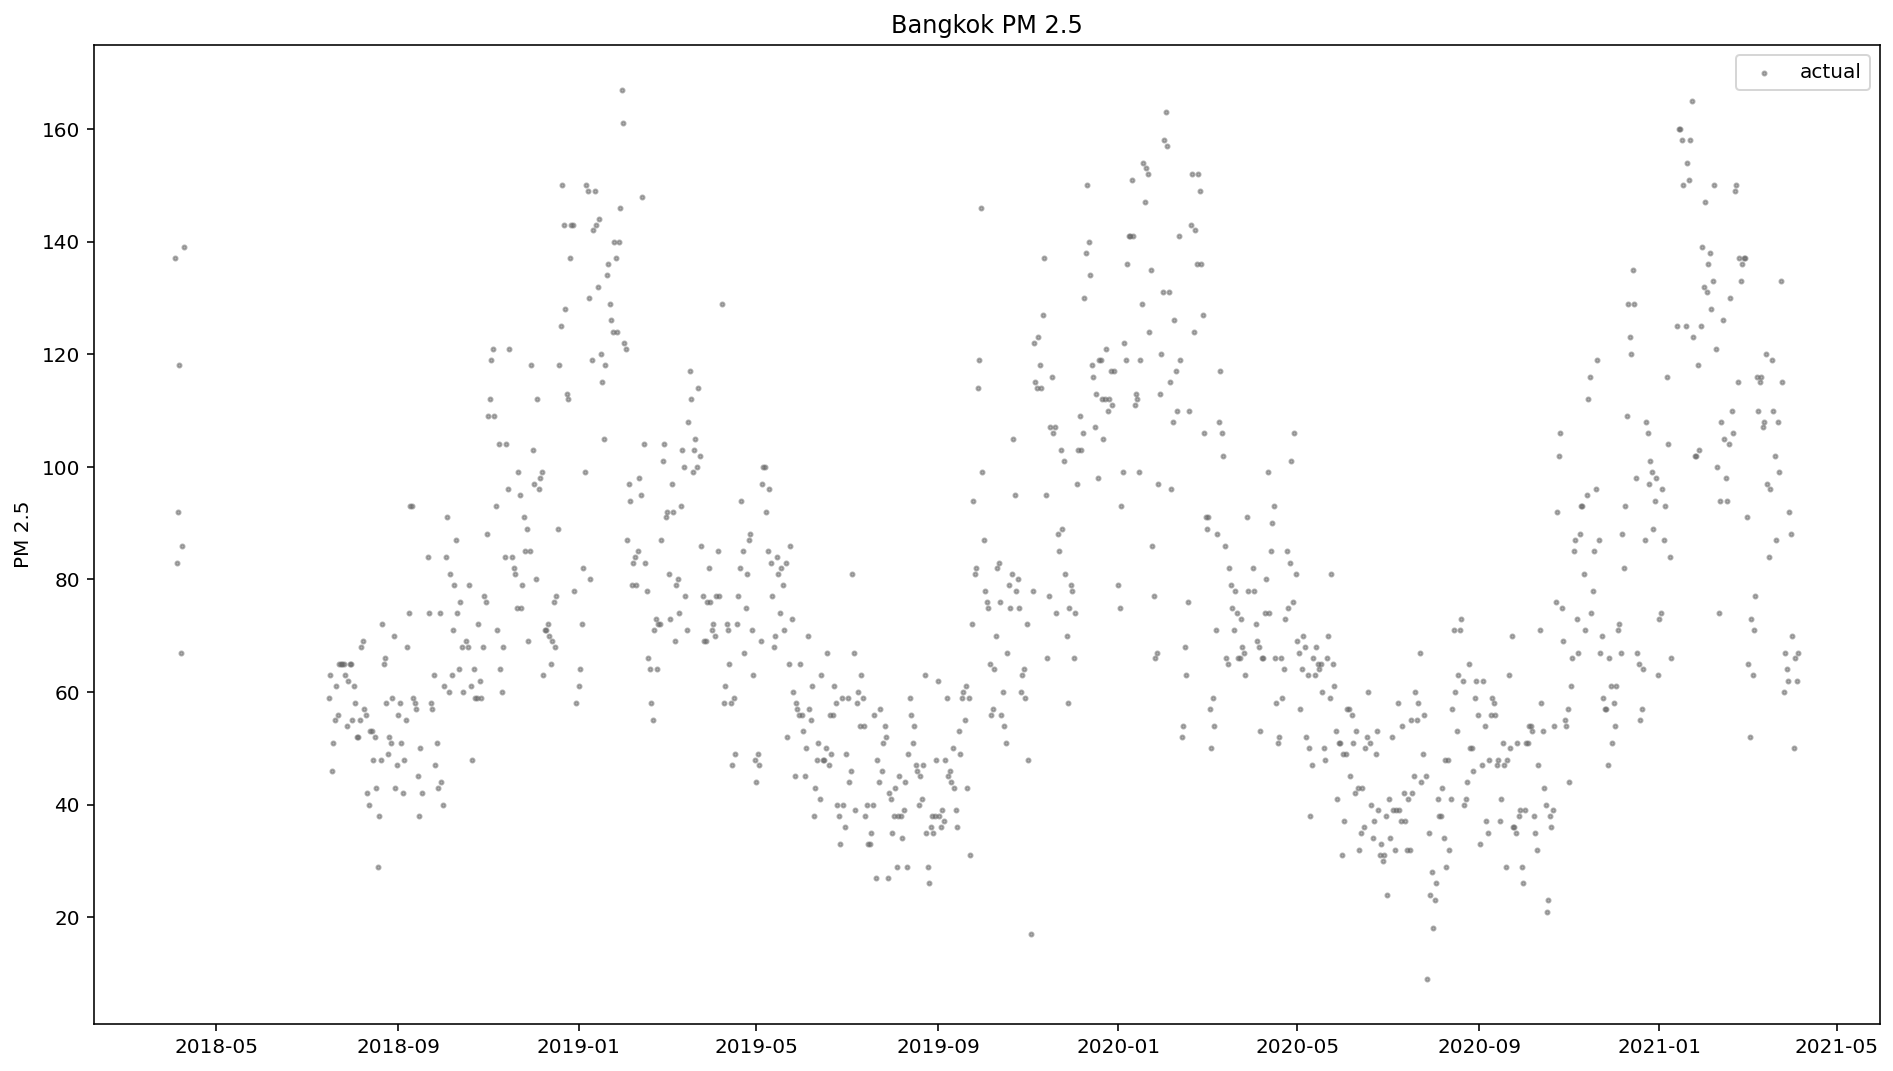

In [14]:
#visualize data
plt.figure(figsize=(16, 9))
plt.scatter(df.index, df[y_col], alpha=.5, s=4, label='actual', color='.4')
plt.ylabel('PM 2.5')
plt.title('Bangkok PM 2.5')
plt.legend();

In [15]:
feature_cols=[
    'year', 'month', 
    'day', 
    'day_name'
]
X=df[feature_cols]
y=df[y_col]

In [16]:
split_at=1400
X_train, X_test, y_train, y_test=X[:split_at], X[split_at:], y[:split_at], y[split_at:]

In [17]:
reg = lgb.LGBMRegressor()
reg.get_params()


{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [18]:
params={'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
}
# reg = lgb.LGBMRegressor()
# reg = lgb.LGBMRegressor(**params)

In [19]:
fit_params={'early_stopping_rounds':200, 
            'eval_set': [(X_test, y_test)],
            'verbose': 10
           }
reg.fit(X_train, y_train, **fit_params)
reg.__dict__

/Users/tou/python_project/data_science/venv/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/tou/python_project/data_science/venv/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/tou/python_project/data_science/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


ValueError: Input data must be 2 dimensional and non empty.

In [ ]:
reg.score(X_train, y_train)

In [ ]:
reg.score(X_test, y_test)

In [ ]:
reg.predict(X_test[:5])

In [ ]:
# visualize forecast
plt.figure(figsize=(16, 9))
plt.scatter(df.index, df[y_col], alpha=.5, s=4, label='actual', color='.4')
plt.scatter(X_train.index, reg.predict(X_train), alpha=.5, s=4, label='predict_X_train', color='deepskyblue')
plt.scatter(X_test.index, reg.predict(X_test), alpha=.5, s=4, label='predict_X_test', color='orange')
plt.ylabel('PM 2.5')
plt.title('Bangkok PM 2.5')
plt.legend();

In [ ]:
df

In [ ]:
import shap
# load JS visualization code to notebook
shap.initjs()


In [ ]:
X

In [ ]:
X.tail

In [ ]:
X.loc[['2021-03-04']]

In [ ]:
Xi=pd.DataFrame([[2016,3,17,'Wednesday']])

In [ ]:
Xi=np.array([[2016,3,17,6]])

In [ ]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(reg)
# shap_values = explainer.shap_values(X.loc[['2021-03-04']])
# shap_values = explainer.shap_values(np.array([[2016,3,17,6]]))
shap_values = explainer.shap_values(X)

In [ ]:
shap_values

In [ ]:
explainer.__dict__

In [ ]:
reg.predict(X_train).mean() # explainer.expected_value

In [ ]:
shap_values[:3]

In [ ]:
shap_values.shape

In [ ]:
X[:5]

In [ ]:
feature_cols

In [ ]:
# shap values of each case
dshap=pd.DataFrame(shap_values, columns=feature_cols)
dshap

In [ ]:
X[:5]

In [ ]:
X.tail()

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

In [ ]:
explainer.shap_values(X)

In [ ]:
def case_detail(case_data):
    '''
    format obj returned from shap.force_plot()
    '''
    de=pd.DataFrame(case_data.data['features'])
    fcols=[]
    for i in case_data.data['features'].keys():
        fcols.append(case_data.data['featureNames'][i])
    de.columns=fcols
    return de

def individual_case_plot(explainer, X, case_index):
    """
    >>> individual_case_plot(explainer, X_train, 1)
    """
    shap_values = explainer.shap_values(X.iloc[[case_index]])
    g=shap.force_plot(explainer.expected_value, shap_values=shap_values, features=X.iloc[case_index, :])
    
#     shap_values = explainer.shap_values(X)
#     g=shap.force_plot(explainer.expected_value, shap_values=shap_values[case_index], features=X.iloc[case_index, :])
#     print('SHAP values')
#     dshap=pd.DataFrame(shap_values, columns=feature_cols)
#     dpos=dshap.iloc[case_index][dshap.iloc[case_index].values > 0].sort_values(ascending=False)
#     dneg=dshap.iloc[case_index][dshap.iloc[case_index].values < 0].sort_values(ascending=False)
#     print(dpos)
#     print(f'sum pos = {dpos.sum():.6f}')
#     print(dneg)
#     print(f'sum neg = {dneg.sum():.6f}')

#     print(f'sum SHAP = {dpos.sum()+dneg.sum():.6f}')
#     print(f'base      value = {explainer.expected_value:.2f}')
#     print(f'predicted value = {explainer.expected_value + dpos.sum() + dneg.sum():.2f}')
#     pprint(g.data)
    return g

In [ ]:
X[:3]

In [ ]:
X.iloc[[3]]

In [ ]:
individual_case_plot(explainer, X, 0)

In [ ]:
g=individual_case_plot(explainer, X, 0)
g
g.__dict__

In [ ]:
de=case_detail(g)
de

In [ ]:
de.loc['effect', :].sum()

In [ ]:
de.loc['effect', :].sum()+g.data['baseValue']

In [ ]:
sum_effect=0
for k, v in g.data['features'].items():
    sum_effect+=v['effect']
sum_effect

In [ ]:
g.data['baseValue'] + sum_effect

In [ ]:
g=individual_case_plot(explainer, X, 120)
g

In [ ]:
case_detail(g)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[:365], X[:365])

In [ ]:
X